In [1]:
import re
import os
import glob
import shutil
import requests
import random
import pandas as pd
import nltk
import pprint
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# 1. Data set path

In [2]:
# Direction of raw data for training
train_path="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/2010_i2b2_data/training_data/"
# Direction of raw data for test
test_path="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/2010_i2b2_data/test_data/"
# Direction of annotated files
tag_path="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/2010_i2b2_data/annotated_file/"

In [3]:
out_data_trainPath="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/out_data/train/"
out_data_testPath="/Users/jill/Downloads/2019_fall_semester/personal_project/nltk_practice/out_data/test/"

# 2. Filenamelist

Make filenames and ID in dataset consistent.

In [4]:
trainfile_lst = [os.path.basename(file) for file in glob.iglob(train_path+'/*.txt')]
testfile_lst = [os.path.basename(file) for file in glob.iglob(test_path+'/*.txt')]

In [5]:
trainfile_lst

['284487129.txt',
 '331144840.txt',
 'record-51.txt',
 'record-45.txt',
 '522011500_ELMVH.txt',
 '641987347_RWH.txt',
 '198175916.txt',
 'record-107.txt',
 '213763231.txt',
 '719127931.txt',
 '558603822.txt',
 '812392414.txt',
 '848649595_SC.txt',
 '063739938_WGH.txt',
 'record-106.txt',
 '020501989_DH.txt',
 '036855076.txt',
 '178557034_RWH.txt',
 '702802626.txt',
 '040059132.txt',
 '305038693.txt',
 '959086752.txt',
 '627258104.txt',
 '522222575.txt',
 '763428002.txt',
 '544677599.txt',
 'record-50.txt',
 '814293840_PUMC.txt',
 '343254953.txt',
 '134300717.txt',
 'record-46.txt',
 '284137413_TH.txt',
 'record-52.txt',
 '578255201_EH.txt',
 '337702516_WGH.txt',
 '891864133_RWH.txt',
 '483275754_YC.txt',
 '262912613.txt',
 '384729825.txt',
 'record-105.txt',
 '898228679_VH.txt',
 '782673825.txt',
 'record-84.txt',
 '101407944_PUMC.txt',
 '186937457.txt',
 'record-53.txt',
 'record-47.txt',
 '839999049_YC.txt',
 '070203832_DH.txt',
 '517414339.txt',
 '914783811.txt',
 '649008161.txt',
 

In [26]:
len(trainfile_lst),len(testfile_lst)

(437, 256)

In [27]:
test_lst = [filename.split('.')[0] for filename in testfile_lst]
test_lst.sort()
df_test_tag = pd.read_csv(tag_path+'/annotated_for_test.txt',sep=',',index_col=False)
df_test_tag['ID'][0] = '0001'

/Users/jill/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
df_test_tag.head()

,ID,HF,CAD,Description
0,0001,1,1,CAD(2)/CHF(3)
1,0002,0,0,NaN
2,0005,0,0,NaN
3,0006,0,1,cardiaccath(1)/CAD(2)
4,0009,0,0,AF(1)


In [29]:
# Check filenames list and data frame ID names are consistent.
df_test_tag.ID.tolist() == test_lst

True

In [30]:
# Concat all data sets annotated for training.
df_beth = pd.read_csv(tag_path+'/annotated_for_beth.txt', sep = ',', index_col=False)
df_partner = pd.read_csv(tag_path+'/annotated_for_partners.txt', sep = ',', index_col=False)
df_partner2 = pd.read_csv(tag_path+'/annotated_for_partners2.txt', sep=',', index_col=False)
df_train_tag = pd.concat([df_beth,df_partner,df_partner2], ignore_index=True)

# Adjust ID names. eg: '044687343 ELMVH' to '044687343_ELMVH'.
id_lst = df_train_tag.ID.tolist()
id_lst2 = [x.replace(" ", "_") for x in id_lst]
df_train_tag['ID'] = id_lst2

# Adjust train file names. eg: 'record-121' to 'record_121'
train_filename_lst = [lst.split('.')[0] for lst in trainfile_lst]
train_filename_lst = [element.replace("-", "_") for element in train_filename_lst]

In [31]:
df_train_tag.head()

,ID,HF,CAD,Description
0,record_13,0,1,CAD(1)
1,record_14,0,0,NaN
2,record_15,1,1,CAD(1) / HF(2)
3,record_16,0,1,CAD(1)
4,record_17,0,0,Rule out myocardial infarction


In [32]:
# train filenames list and data frame ID names are consistent.
train_filename_lst.sort() == df_train_tag.ID.tolist().sort()

True

In [33]:
df_train_tag.CAD.value_counts()

0    333
1    104
Name: CAD, dtype: int64

In [34]:
df_test_tag.CAD.value_counts()

0    192
1     64
Name: CAD, dtype: int64

# 3. Create a columns "text" concated file content with ID

In [35]:
def concat_df(df,filenamelist,col_list,path):
    """
    Concat text and CAD columns with same ID
    Return the merged dataframe.
    """
    df1 = pd.DataFrame(df)[col_list]
    id_lst = []
    text_lst = []
    
    def read_text(text):
        with open(text, "r") as file:
            raw = file.readlines()
        return raw

    for file in filenamelist:
        id_lst.append(file.split('.')[0])
        text = read_text(path+file)
        text_lst.append(text)
        
    id_lst = [file.replace("-","_") for file in id_lst]
    lst_of_tuples = list(zip(id_lst, text_lst))
    df2 = pd.DataFrame(lst_of_tuples, columns = ['ID','text'])    
    merge_df = pd.merge(left = df1,right=df2, left_on='ID', right_on='ID')
    return merge_df    

In [36]:
colLst = ['ID','CAD']
merge_train = concat_df(df_train_tag, trainfile_lst, colLst, train_path)
merge_test = concat_df(df_test_tag, testfile_lst, colLst, test_path)

In [37]:
merge_train.head()

,ID,CAD,text
0,record_13,1,"[Admission Date :\n, 2018-10-25\n, Discharge D..."
1,record_14,0,"[Admission Date :\n, 2011-03-10\n, Discharge D..."
2,record_15,1,"[Admission Date :\n, Discharge Date :\n, 2014-..."
3,record_16,1,"[Admission Date :\n, 2015-10-28\n, Discharge D..."
4,record_17,0,"[Admission Date:\n, 2011-02-08\n, Discharge Da..."


In [38]:
merge_train.shape

(437, 3)

In [39]:
merge_train.CAD.value_counts()

0    333
1    104
Name: CAD, dtype: int64

In [40]:
merge_test.head()

,ID,CAD,text
0,0001,1,"[﻿Admission Date :\n, 2012-10-31\n, Discharge ..."
1,0002,0,"[004668411\n, CTMC\n, 68299235\n, 763052\n, 9/..."
2,0005,0,"[﻿Admission Date :\n, 2016-12-24\n, Discharge ..."
3,0006,1,"[006544894 \n, NVH \n, 65104826 \n, 1/2/2004 1..."
4,0009,0,"[﻿Admission Date :\n, 2015-10-10\n, Discharge ..."


In [41]:
merge_test.shape

(256, 3)

In [42]:
merge_test.CAD.value_counts()

0    192
1     64
Name: CAD, dtype: int64

# 4. Processing sentences, preparing datasets.

In [43]:
def cleanText(sentence):
    """
    Remove special characters and numbers.
    change all letters into lowercase.
    
    """ 
    return re.sub('[^a-zA-Z]+',' ', sentence).lower()

In [44]:
def normalize_word(sentence):
    """
    Remove stop words, stem and lemmatize words.
    Return a new words list.
    """
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    word_tokens = word_tokenize(sentence)
    
    # Remove stop words
    filtered_words = [w for w in word_tokens if w not in stop_words]
    
    # Stem
    stem_words = [ps.stem(w) for w in filtered_words]
    
    # Lemmatize
    lemma_words = [WordNetLemmatizer().lemmatize(w) for w in stem_words]
    
    # Create a list having the words whose length are larger than 1.
    words = [word for word in lemma_words if len(word)>1]
    return words

In [45]:
def token_words(lst):
    """
    Return a list of word tokens from text.
    """
    new_lst = []
    for sentence in lst:
        # Remove words of categories
        if ":" not in sentence:
            clean_sen = cleanText(sentence)
            if clean_sen != ' ':
                new_sen = normalize_word(clean_sen) 
                if new_sen:
                    new_lst+=new_sen
    return new_lst

In [46]:
def prepared_data(df, df_dir, filename):
    """
    Create columns "word_tokens","clean_text".
    Shuffle the indexes.
    Write a csv file used for model to the target path.
    """
    df['word_tokens'] = df.apply(lambda x: token_words(x['text']),axis=1)
    df['clean_text'] = df.apply(lambda x: " ".join(x['word_tokens']),axis=1)
    df_new = shuffle(df, random_state=42)
    df_new.reset_index(drop=True)
    df_new.to_csv(os.path.join(df_dir,filename), encoding='utf-8', index = None,header='true')
    

In [49]:
%%time
prepared_data(merge_train, out_data_trainPath, "train.csv")
prepared_data(merge_test, out_data_testPath, "test.csv")

CPU times: user 17.1 s, sys: 1.65 s, total: 18.7 s
Wall time: 18.8 s


# 5. EDA
references: https://github.com/Jill3240/NLP-with-Python/blob/master/sentiment_analysis.ipynb

In [50]:
Training = pd.read_csv(os.path.join(out_data_trainPath,"train.csv"), index_col=False)
Test = pd.read_csv(os.path.join(out_data_testPath,"test.csv"), index_col=False)

#### *EDA of Traing dataset*

In [51]:
Training.shape

(437, 5)

In [52]:
Training.head()

,ID,CAD,text,word_tokens,clean_text
0,857888116,1,"['857888116\n', 'CTMC\n', '36320247\n', '66801...","['ctmc', 'leukemia', 'pnuemoia', 'bone', 'marr...",ctmc leukemia pnuemoia bone marrow transplant ...
1,095889687_WGH,0,"['095889687 WGH\n', '9786774\n', '224527\n', '...","['wgh', 'ed', 'discharg', 'summari', 'unsign',...",wgh ed discharg summari unsign di unsign ed di...
2,428878172_ELMVH,0,"['428878172 ELMVH\n', '77066399\n', '833854\n'...","['elmvh', 'vagin', 'birth', 'di', 'discharg', ...",elmvh vagin birth di discharg order liepkol zo...
3,511454195,0,"['511454195\n', 'HLGMC\n', '0150441\n', '60106...","['hlgmc', 'discharg', 'summari', 'sign', 'di',...",hlgmc discharg summari sign di sign fongfyfeno...
4,601874915,1,"['601874915\n', 'TGCHO\n', '7350631\n', '48597...","['tgcho', 'discharg', 'summari', 'unsign', 'di...",tgcho discharg summari unsign di unsign right ...


In [53]:
Training.CAD.value_counts()

0    333
1    104
Name: CAD, dtype: int64

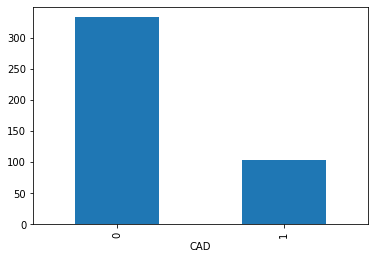

In [54]:
Training.groupby("CAD")['ID'].count().plot.bar()

In [55]:
Training.isnull().values.any(), Training.isnull().values.sum()

(False, 0)

#### *EDA of Test dataset*

In [56]:
Test.shape

(256, 5)

In [57]:
Test.head()

,ID,CAD,text,word_tokens,clean_text
0,445,0,"['Admission Date :\n', '2015-04-16\n', 'Discha...","['surgeri', 'patient', 'record', 'known', 'all...",surgeri patient record known allergi drug alte...
1,13,0,"['Admission Date :\n', '2016-05-05\n', 'Discha...","['neonatolog', 'patient', 'week', 'gestat', 'f...",neonatolog patient week gestat femal triplet n...
2,158,0,"['207132235 SC\n', '51203606\n', '132775\n', '...","['sc', 'endometri', 'carcinoma', 'sign', 'di',...",sc endometri carcinoma sign di sign endometri ...
3,412,0,"['Admission Date :\n', '2015-08-10\n', 'Discha...","['ct', 'cmed', 'csru', 'mr', 'bruno', 'year', ...",ct cmed csru mr bruno year old gentleman initi...
4,234,1,"['325924358\n', 'FIH\n', '7061594\n', '795820\...","['fih', 'coronari', 'arteri', 'diseas', 'unsig...",fih coronari arteri diseas unsign di unsign tl...


In [58]:
Test.CAD.value_counts()

0    192
1     64
Name: CAD, dtype: int64

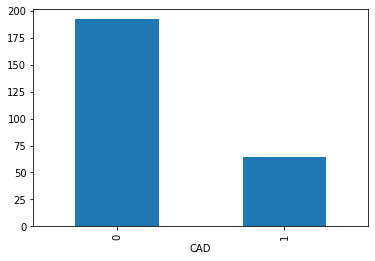

In [59]:
Test.groupby('CAD')['ID'].count().plot.bar()

In [60]:
Test.isnull().values.any(), Test.isnull().values.sum()

(False, 0)

#### *Visuliazation of words in training dataset*

In [61]:
def visulization_data(df):
    """
    Make a wordcloud visualization of the data
    """
    df_pos = df.loc[df['CAD'] == 1]
    df_neg = df.loc[df['CAD'] == 0]
    combined_text_pos = " ".join([word for word in df_pos['word_tokens'].tolist()])
    combined_text_neg = " ".join([word for word in df_neg['word_tokens'].tolist()])
    
    wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
               stopwords = STOPWORDS)
    
    print ("************ CAD_positive words ***********")
    plt.imshow(wc.generate(combined_text_pos))
    plt.axis('off')
    plt.show()
    
    print ("************ CAD_negtive words ************")
    plt.imshow(wc.generate(combined_text_neg))
    plt.axis('off')
    plt.show()

************ CAD_positive words ***********


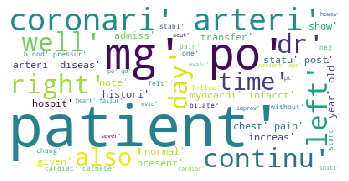

************ CAD_negtive words ************


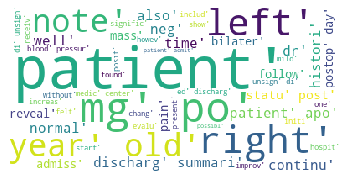

In [62]:
visulization_data(Training)